# ATOC 4500 Project: Cluster Analysis of Colorado Seasons
Authors: Sydney Crandall and Alyssa Ripley

Last edited: April 5th, 2022 at 6:45pm

In [161]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans, whiten
import datetime

In [118]:
# read in data
limonDF = pd.read_csv("Limon_2012-2021_hourlydata_munged.csv")
grandJunctionOrigDF = pd.read_csv("72476023066_GrandJunction_2002-2021_hourlydata_munged.csv")
boulderDF = pd.read_csv("72053300160_Boulder_2012-2021_hourlydata_munged.csv")
eagleDF = pd.read_csv("72467523063_Eagle_2012-2021_hourlydata_munged.csv")

In [119]:
# Look at Limon Dataframe
#limonDF.head(10)

In [120]:
# look at Boulder Dataframe
#boulderDF.head(10)

In [121]:
# look at Eagle Dataframe
#eagleDF.head(50)

In [122]:
# look at Grand Junction Dataframe 
#grandJunctionOrigDF.head(10)

# the Grand Junction dataframe starts at an earlier date than the other 3 (2002 vs. 2012)
# adjust grandJunctionDF to only include the values we need (match up with the other datasets)

In [123]:
# find the row number closest to the start of the other datasets
grandJunctionOrigDF.loc[128691] # this is the closest to the start of the other datasets
 
# create a new dataframe for new time period ( from the closest to the start of the other datasets to the end)
grandJunctionDF = grandJunctionOrigDF[128692:]
grandJunctionDF.index = range(len(grandJunctionDF)) # adjust the row indices to start at 0
#grandJunctionDF.head(10)
# there is a repeat value every 7th row, remove this

In [138]:
# add columns for day, month, year, hour, and minute
limonDF["datetime"] = pd.to_datetime(limonDF["datetime"])
limonDF["year"] = limonDF["datetime"].dt.year
limonDF["month"] = limonDF['datetime'].dt.month
limonDF["day"] = limonDF['datetime'].dt.day
limonDF["hour"] = limonDF["datetime"].dt.hour

boulderDF["datetime"] = pd.to_datetime(boulderDF["datetime"])
boulderDF["year"] = boulderDF["datetime"].dt.year
boulderDF["month"] = boulderDF['datetime'].dt.month
boulderDF["day"] = boulderDF['datetime'].dt.day
boulderDF["hour"] = boulderDF['datetime'].dt.hour

eagleDF["datetime"] = pd.to_datetime(eagleDF["datetime"])
eagleDF["year"] = eagleDF["datetime"].dt.year
eagleDF['month'] = eagleDF['datetime'].dt.month
eagleDF["day"] = eagleDF['datetime'].dt.day
eagleDF['hour'] = eagleDF['datetime'].dt.hour

grandJunctionDF["datetime"] = pd.to_datetime(grandJunctionDF["datetime"])
grandJunctionDF["year"] = grandJunctionDF["datetime"].dt.year
grandJunctionDF["month"] = grandJunctionDF['datetime'].dt.month
grandJunctionDF["day"] = grandJunctionDF['datetime'].dt.day
grandJunctionDF['hour'] = grandJunctionDF["datetime"].dt.hour

C:\Users\Sydney\AppData\Local\Temp/ipykernel_13136/3345385113.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grandJunctionDF["datetime"] = pd.to_datetime(grandJunctionDF["datetime"])
C:\Users\Sydney\AppData\Local\Temp/ipykernel_13136/3345385113.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grandJunctionDF["year"] = grandJunctionDF["datetime"].dt.year
C:\Users\Sydney\AppData\Local\Temp/ipykernel_13136/3345385113.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [144]:
# add columns for season
# from Homework 4
seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}

# function for relating season to month
def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k] 
        
limonDF['season']= [season(month) for month in pd.DatetimeIndex(limonDF['datetime']).month]
boulderDF['season']=[season(month) for month in pd.DatetimeIndex(boulderDF['datetime']).month]
eagleDF['season']=[season(month) for month in pd.DatetimeIndex(eagleDF['datetime']).month]
grandJunctionDF['season']=[season(month) for month in pd.DatetimeIndex(grandJunctionDF['datetime']).month]

# check one of the datasets to make sure it worked
#limonDF.query("season == 3")

C:\Users\Sydney\AppData\Local\Temp/ipykernel_13136/4020685223.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grandJunctionDF['season']=[season(month) for month in pd.DatetimeIndex(grandJunctionDF['datetime']).month]


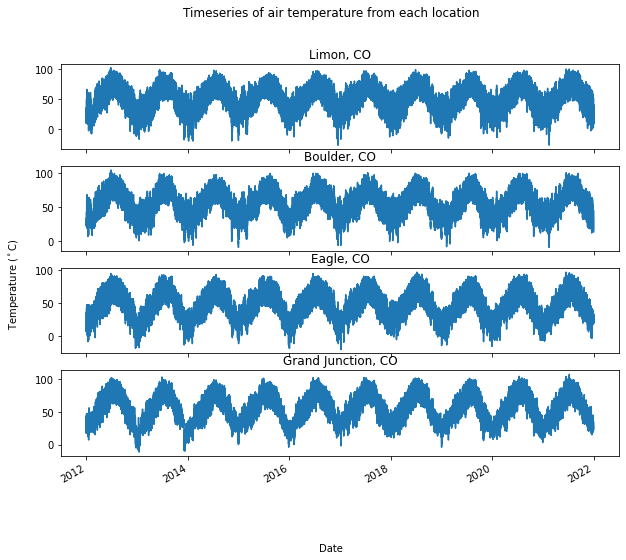

In [145]:
# graph timeseries subplots of temperature for the first 10 datapoint at all locations 
# this can be used to show that we looked at our data

fig, ax = plt.subplots(4, figsize = (10,8))
fig.suptitle("Timeseries of air temperature from each location")
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Temperature ($^\circ$C)', ha='center', va='center', rotation='vertical')

fig.autofmt_xdate()

# subplot 1: Limon
ax[0].plot(limonDF["datetime"],limonDF["drytemp_F"])
ax[0].set_title("Limon, CO")

# subplot 2: Boulder
ax[1].plot(boulderDF["datetime"], boulderDF["drytemp_F"])
ax[1].set_title("Boulder, CO")

# subplot 3: Eagle
ax[2].plot(eagleDF["datetime"], eagleDF["drytemp_F"])
ax[2].set_title("Eagle, CO")

# subplot 4: Grand Junction
ax[3].plot(grandJunctionDF["datetime"], grandJunctionDF["drytemp_F"])
ax[3].set_title("Grand Junction, CO")
fig.savefig("Look_at_data.jpg")

### select time function

In [131]:
def select_time(df, hour):
    selectdf = df[df.hour==hour]
    return(selectdf)

In [160]:
included_cols = ["drytemp_F", 'dewtemp_F', 'prec_inch', 'RH', 'pres_mbar', 'wdir', 'wspd_mph','wgust_mph']

In [169]:
def scale_and_convert_to_numpy(selectdf, included_cols):
    data = selectdf.loc[:, selectdf.columns.isin(list(included_cols))].to_numpy()
    scaled_data = whiten(data)
    return scaled_data

In [175]:
def cluster_data(NO_CLUSTERS, scaled_data):
    centroids, _  = kmeans(scaled_data,NO_CLUSTERS,iter=20)
    idx, _ = vq(scaled_data,centroids)
    idx=idx+1
    return idx

In [207]:
def seasonal_assignment_by_year(idx, city):
    plt.figure(figsize = (10,6))
    plt.plot(idx[0:365],'.',label='2012');
    plt.plot(idx[365:365*2]+0.07,'.',label='2013');
    plt.plot(idx[365*2:365*3]+0.14,'.',label='2014');
    plt.plot(idx[365*3:365*4]+0.21,'.',label='2015');
    plt.plot(idx[365*4:365*5]+0.28,'.',label='2016');
    plt.plot(idx[365*5:365*6]+0.35,'.',label='2017');
    plt.plot(idx[365*6:365*7]+0.42,'.',label='2018');
    plt.plot(idx[365*7:365*8]+0.49,'.',label='2019');
    plt.plot(idx[365*8:365*9]+0.56,'.',label='2020');
    plt.plot(idx[365*9:365*10]+0.63,'.',label='2021');
    #plt.legend(loc='best');
    plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', ncol=1);
    plt.yticks(ticks = np.arange(1.25,NO_CLUSTERS+1.25),labels=['cluster1','cluster2','cluster3','cluster4']);
    plt.xlabel('Day of the year')
    plt.title('Seasonal cycle of cluster assignment by Year for '+city);

## Limon Cluster Analysis
- use **limonDF** at approximately noon
- start with 4 clusters, then 3 and 2
- if time, use **limonDF** at other times (early morning, midnight, afternoon)

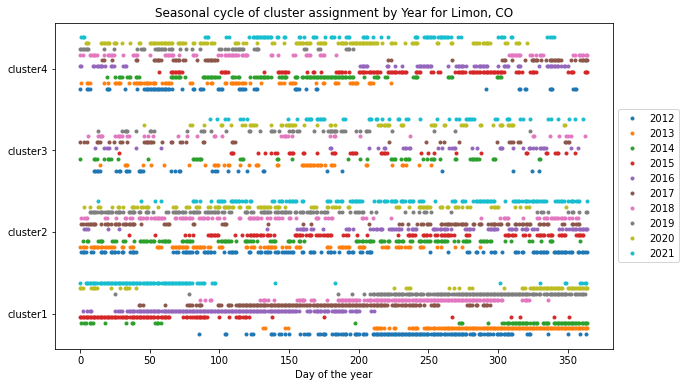

In [209]:
limonClusterDF = select_time(limonDF,12)
limonScaled = scale_and_convert_to_numpy(limonClusterDF,included_cols)
NO_CLUSTERS = 4 # change this to change the number of clusters
limonIdx = cluster_data(NO_CLUSTERS,limonScaled)
seasonal_assignment_by_year(limonIdx, "Limon, CO")

## Boulder Cluster Analysis
- use **boulderDF** at approximately noon 
- start with 4 clusters, then 3 and 2
- if time, use **boulderDF** at other times (early morning, midnight, afternoon)

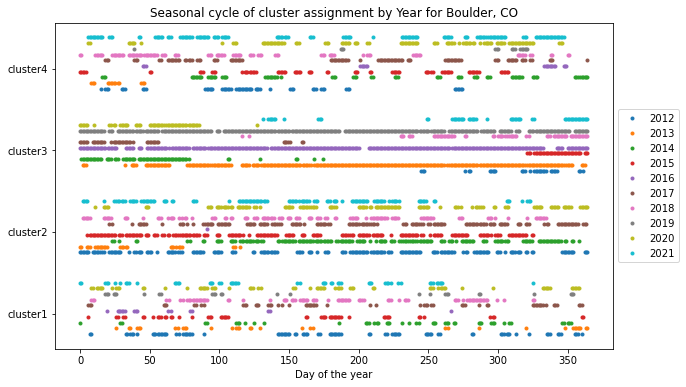

In [211]:
boulderClusterDF = select_time(boulderDF,12)
boulderScaled = scale_and_convert_to_numpy(boulderClusterDF,included_cols)
NO_CLUSTERS = 4 # change this to change the number of clusters
boulderIdx = cluster_data(NO_CLUSTERS,boulderScaled)
seasonal_assignment_by_year(boulderIdx, "Boulder, CO")

## Eagle Cluster Analysis
- use **eagleDF** at approximately noon
- start with 4 clusters, then 3 and 2
- if time, use **eagleDF** at other times (early morning, midnight, afternoon)

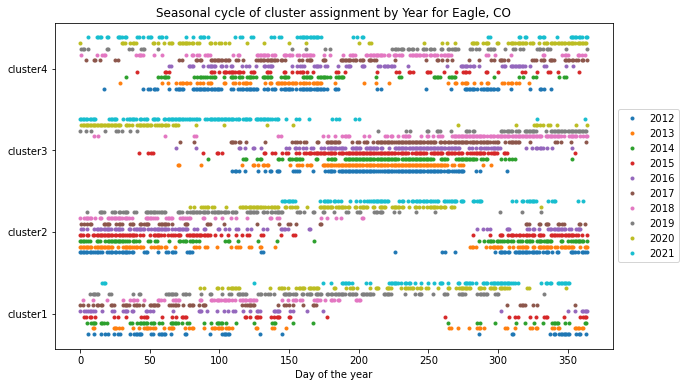

In [212]:
eagleClusterDF = select_time(eagleDF,12)
eagleScaled = scale_and_convert_to_numpy(eagleClusterDF,included_cols)
NO_CLUSTERS = 4 # change this to change the number of clusters
eagleIdx = cluster_data(NO_CLUSTERS,eagleScaled)
seasonal_assignment_by_year(eagleIdx, "Eagle, CO")

## Grand Junction Cluster Analysis
- use **grandJunctionDF** at approximately noon
- start with 4 clusters, then 3 and 2
- if time, use **grandJunctionDF** at other times (early morning, midnight, afternoon)

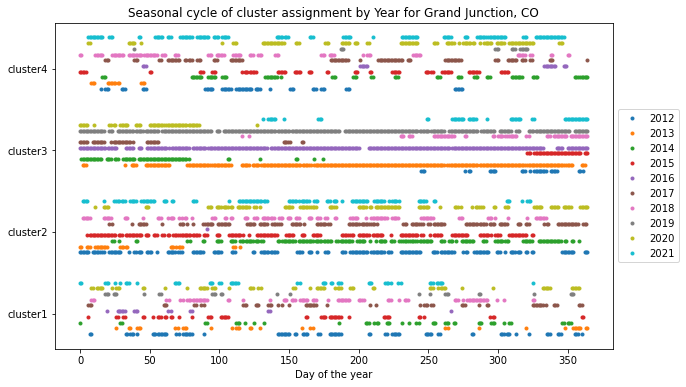

In [213]:
grandJunctionClusterDF = select_time(grandJunctionDF,12)
grandJunctionScaled = scale_and_convert_to_numpy(grandJunctionClusterDF,included_cols)
NO_CLUSTERS = 4 # change this to change the number of clusters
grandJunctionIdx = cluster_data(NO_CLUSTERS,grandJunctionScaled)
seasonal_assignment_by_year(boulderIdx, "Grand Junction, CO")